## Aflevering 2

In [11]:
import os
import pandas as pd
file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from pmdarima import pipeline, arima, model_selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
import warnings
import numpy as np

warnings.filterwarnings("ignore")

#### Task 1

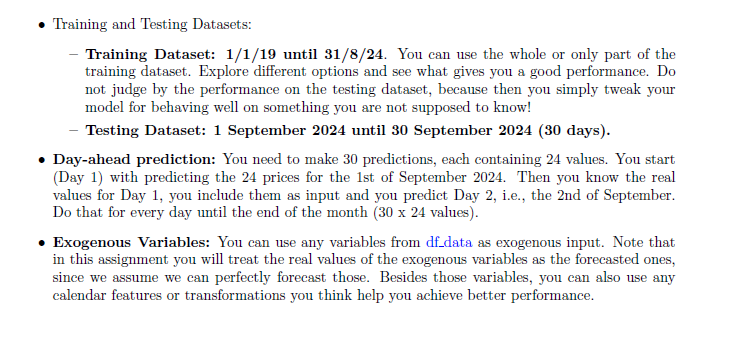

##### Defining the time series. It is assumed, that september 2023 is similar to september 2024, the analysis is therefore based on 2023

In [33]:
#Define training and testing periods
train_start = '2023-04-01'
train_end = '2023-08-31'
test_start = '2023-09-01'
test_end = '2023-09-30'


# Split the data from Elspotprices2nd
train = df_prices[(df_prices['HourUTC'] >= train_start) & (df_prices['HourUTC'] <= train_end)]
test = df_prices[(df_prices['HourUTC'] >= test_start) & (df_prices['HourUTC'] <= test_end)]

# Split the data from ProdConData
train_set_P = df_data[(df_prices['HourUTC'] >= train_start) & (df_data['HourUTC'] <= train_end)]
test_set_P = df_data[(df_prices['HourUTC'] >= test_start) & (df_data['HourUTC'] <= test_end)]
n = len(train['SpotPriceDKK'])
N = len(df_prices['SpotPriceDKK'])
df_data['SpotPriceDKK'] = df_prices["SpotPriceDKK"]

Antager at vi skal starte med at lave ACF og PACF for at finde ud af hvordan vi fitter modellerne

#### Firstly daily and weekly ACF and PACF is found, to get an estimate on what p and q has to be:

##### Daily

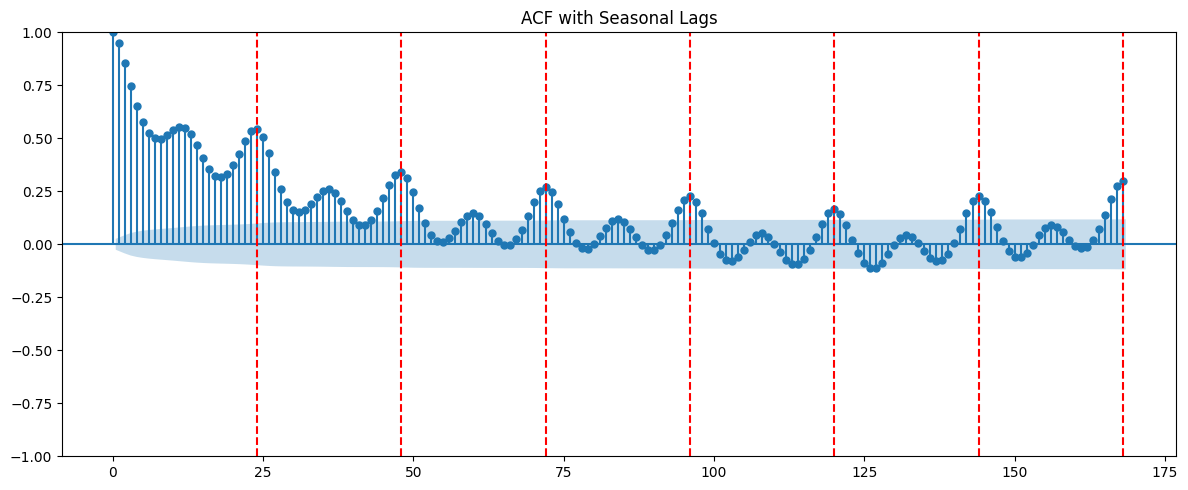

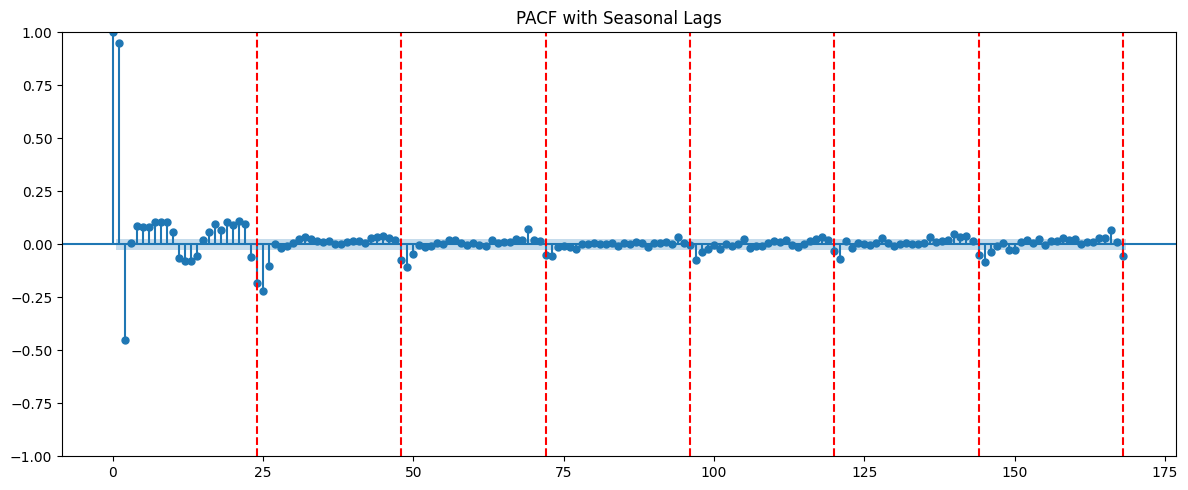

In [31]:
seasonal_period = 24  # e.g., weekly seasonality for hourly data
max_lags = 24 * 7     # show 7 seasonal cycles

# ACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("ACF with Seasonal Lags")
plt.tight_layout()
plt.show()

# PACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, method='ywm', ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("PACF with Seasonal Lags")
plt.tight_layout()
plt.show()


##### Weekly

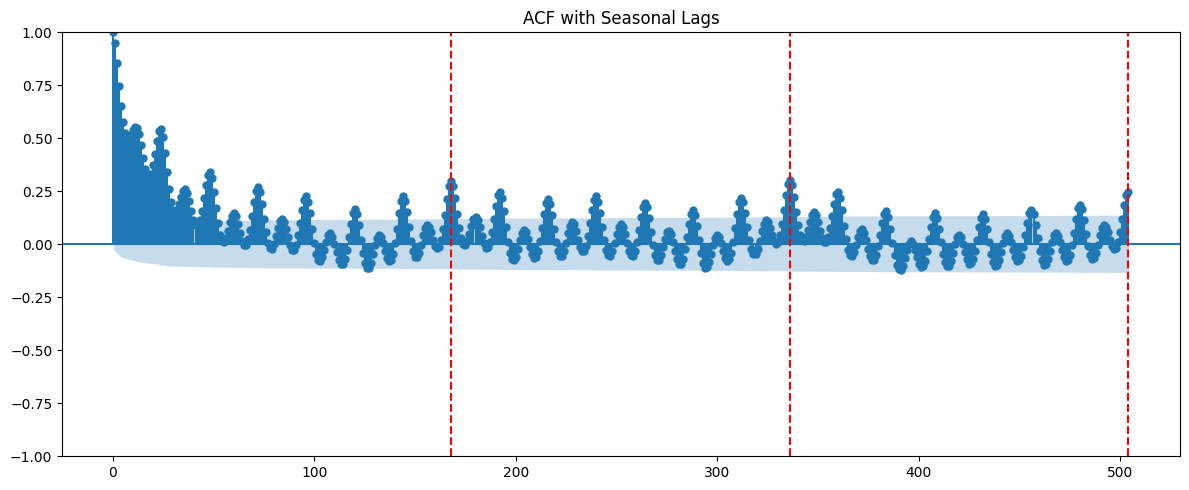

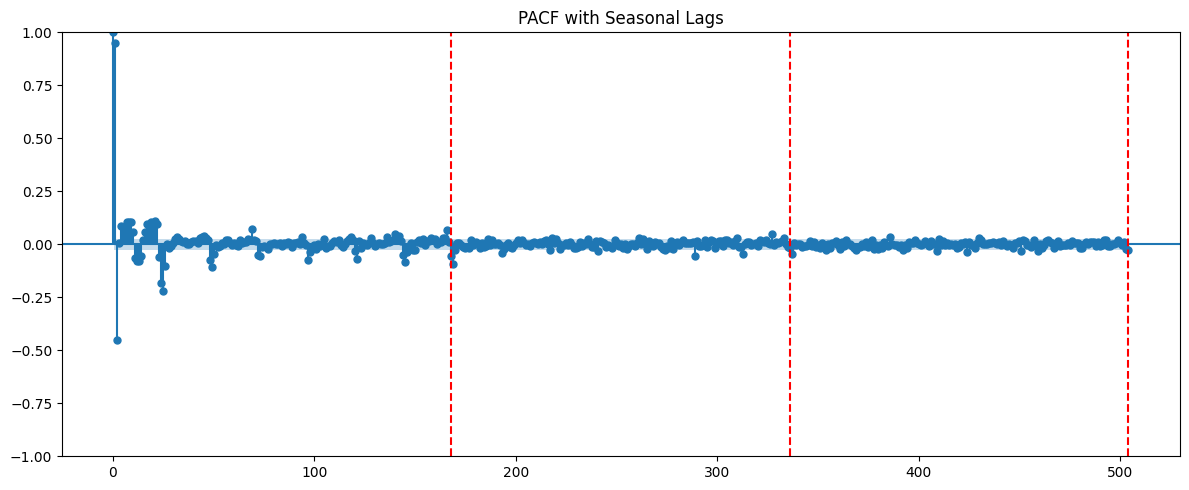

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

seasonal_period = 168  # e.g., weekly seasonality for hourly data
max_lags = 168 * 3     # show 3 seasonal cycles

# ACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("ACF with Seasonal Lags")
plt.tight_layout()
plt.show()

# PACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, method='ywm', ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("PACF with Seasonal Lags")
plt.tight_layout()
plt.show()


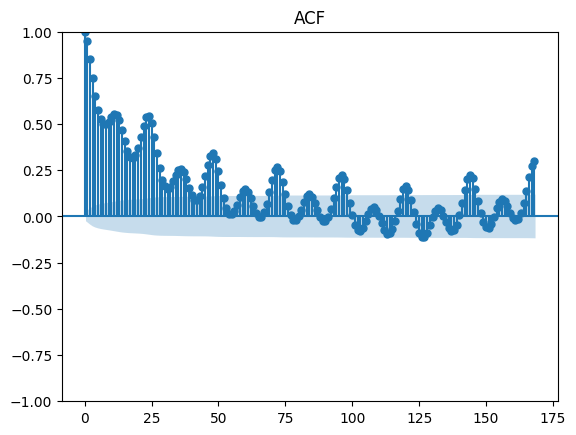

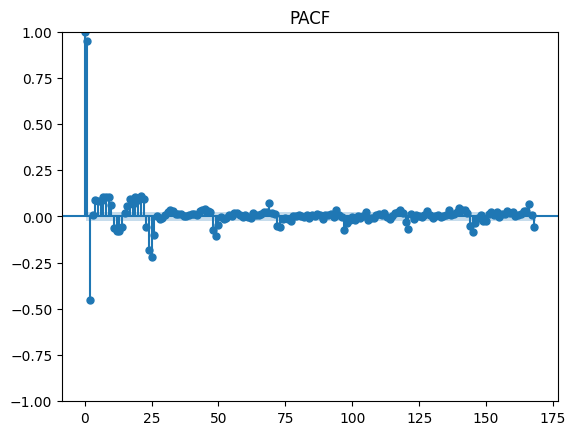

In [24]:
# Check ACF plot
pm.plot_acf(train['SpotPriceDKK'], lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(train['SpotPriceDKK'], method='ywm', lags=168, title = "PACF", alpha = 0.05);


## Task 1

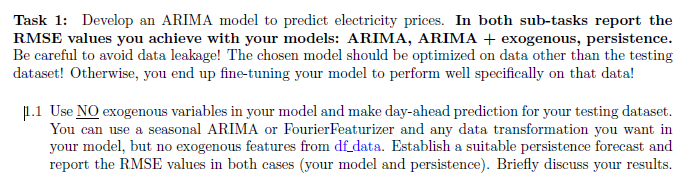

### Differentiere for at forsøge at lave et stationært dataset

Text(0, 0.5, 'x')

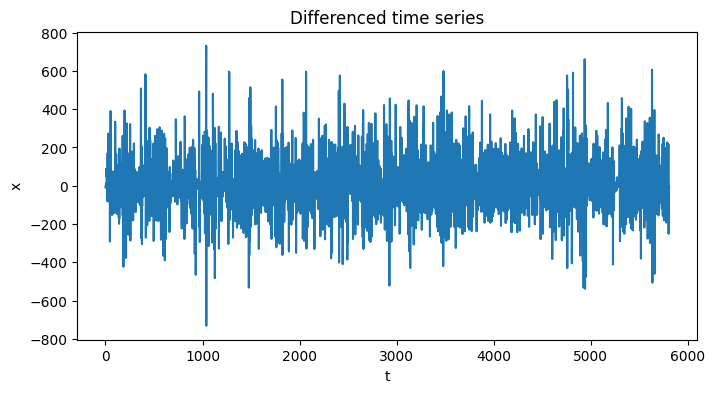

In [26]:
# Calculate the first difference

train['Diff'] = train['SpotPriceDKK'].diff()
diff_data = np.diff(train['SpotPriceDKK'])

# Plot the result
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Differenced time series")
plt.plot(range(0,n-1), diff_data)
plt.xlabel("t")
plt.ylabel("x")

##### Diff

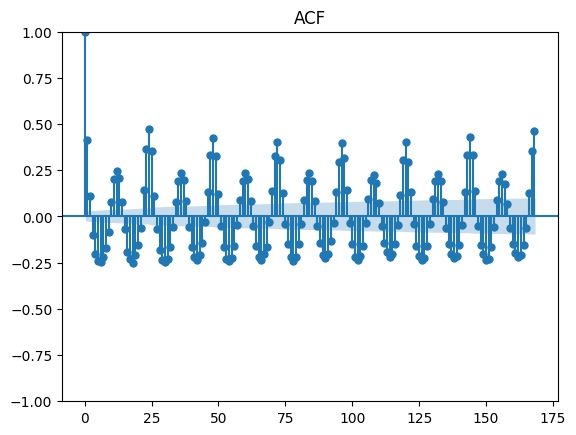

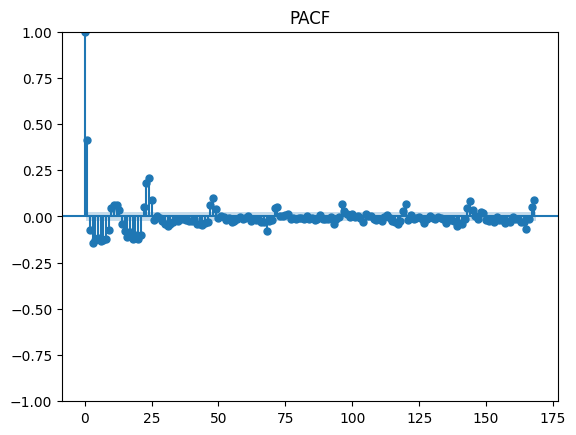

In [28]:
# Check ACF plot
pm.plot_acf(diff_data, lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(diff_data, method='ywm', lags=168, title = "PACF", alpha = 0.05);


## Finder ud af hvilken Arima model som er smart

#### Auto modeller

In [35]:
# # auto_arima search

# model = pm.auto_arima(
#     train['SpotPriceDKK'],         # your time series
#     start_p=0, max_p=3,             # non-seasonal AR
#     start_q=0, max_q=3,             # non-seasonal MA
#     d=None,                         # choose d 
#     seasonal=True,
#     start_P=0, max_P=3,             # seasonal AR
#     start_Q=0, max_Q=3,             # seasonal MA
#     D=None,                         # choose D
#     m=24,                           # seasonal period - one day
#     trace=True,                     # print models tried
#     error_action='ignore',          # skip models that fail
#     suppress_warnings=True,         # silence warnings
#     stepwise=True,                  # stepwise search to speed things up
#     n_fits=50                       # limit total fits (optional)
# )



In [5]:
model = pm.auto_arima(train['SpotPriceDKK'], trace = True, seasonal = True, stepwise=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=69924.135, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70396.886, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=70505.536, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71488.034, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=70285.758, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70182.320, Time=0.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=69892.826, Time=0.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=69890.733, Time=0.98 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70251.640, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=69862.311, Time=1.59 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=70160.744, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=69859.359, Time=1.70 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=70079.923, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0

In [31]:
model2 = pm.auto_arima(diff_data, 
                       trace = True, 
                       seasonal = True, 
                       stepwise=True, 
                       maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=69924.217, Time=1.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=70396.888, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70505.537, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=71488.034, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=70285.757, Time=1.61 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=70181.932, Time=1.64 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=69892.837, Time=1.56 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=69890.953, Time=1.55 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=70251.642, Time=0.45 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=69862.026, Time=2.24 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=70160.747, Time=0.48 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=69859.359, Time=2.77 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=70079.926, Time=0.84 sec
 ARIMA(5,0,2)(0,0,0

ARIMA(1,0,2) på diff data er det bedste. Dette kan også ses ved 

#### Task 1,1

#### Laver en diagnostics

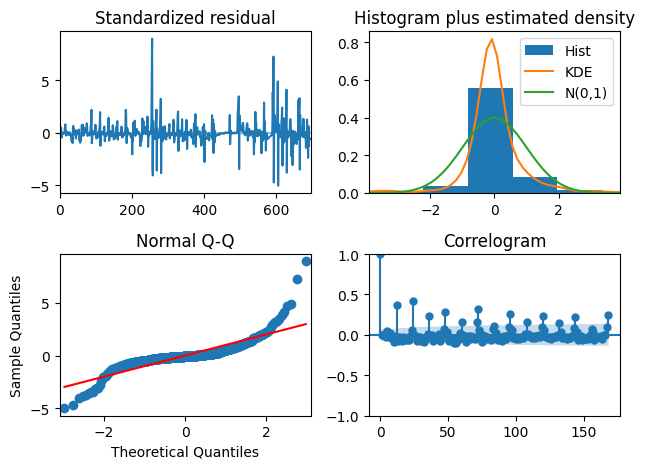

Summary of differentiated data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  697
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -4674.222
Date:                Thu, 10 Apr 2025   AIC                           9364.444
Time:                        17:01:09   BIC                           9400.807
Sample:                             0   HQIC                          9378.504
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2238      0.961     -0.233      0.816      -2.108       1.661
ar.L1          1.1147      0.029     37.970      0.000       1.057       1.172
ar.L2         -0.4555

In [6]:
model = pm.arima.ARIMA(order=(5,1,1))
model.fit(test['SpotPriceDKK'])
model_diagnostics = model.plot_diagnostics(lags=168, fig=plt.figure())
plt.tight_layout()
plt.show()
print("Summary of differentiated data")
print(model.summary())

Kigger på Ljung-Box som skal være lille, en prob som er høj og AIC og BIC som er lave

##### Her laver jeg funktionen i en uge uden at putte den i en funktion

In [ ]:
frc_values = []
train_cutout = train['SpotPriceDKK'].values[1:168]
test_cutout = test['SpotPriceDKK'].values[1:168]

model =pm.arima.ARIMA(order=(5,1,1)) 
model.fit(train_cutout)

 
for k in range(len(test_cutout)):
    m = model.predict(1)[0]
    frc_values.append(m)
    model.update(test[k])

rmse_AR = sqrt(mean_squared_error(test_cutout, frc_values))
MAE_AR = mean_absolute_error(test_cutout, frc_values)

print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
train = train['SpotPriceDKK'].values
test = test['SpotPriceDKK'].values
data = df_prices['SpotPriceDKK'].values[0:168]

##### Laver forecaster funktion

In [42]:
model_forsøg = pm.arima.ARIMA((1,1,1),(0,1,1,24))

In [ ]:
def Create_Sarima(train, order=None, seasonal_order=None):
    # Create the model
    if seasonal_order is None:
        if order is None:
            print("Non seasonal model with no order specified")
            print("Using auto_arima to find the best order")
            model = pm.auto_arima(train, seasonal=False)
        else:
            print("Non seasonal model with order specified")
            print("Using the specified order")
            model = pm.arima.ARIMA(order=order,seasonal=False)
            model.fit(train)
    elif order is None or type(seasonal_order) is not tuple:
        try:
            m = seasonal_order[-1]
        except TypeError:
            m = seasonal_order
        print("Seasonal model missing order")
        print("Using auto_arima to find the best order with m=", m)
        model = pm.auto_arima(train, seasonal=True, m=m)
    else:
        m = seasonal_order[-1]
        print("Seasonal model with order specified")
        print("Using the specified order with m=", m)
        model = pm.arima.ARIMA(order=order, seasonal_order=seasonal_order)
        model.fit(train)
        
    print(model.summary())
    return model

def Forecaster(test, model, n=1):
    
    # Split the dataset into training and testing dataset
    frc_values = []
    
    # Perform the forecasts
    for k in range(int(len(test)/n)):
        print("Forecasting period", k+1)
        frc = model.predict(n_periods=n)
        frc_values.extend(frc)
        model.update(test[k*n:(k+1)*n])

    # Calculate error metrics
    rmse_AR = sqrt(mean_squared_error(test, frc_values))
    MAE_AR = mean_absolute_error(test, frc_values)
    print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
    print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))
    
    return frc_values

def Create_Fourier_Pipe(train, m=24*7,k=24):
    pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=m, k = k)),
    ("arima", arima.AutoARIMA(stepwise=False, trace = False, error_action="ignore",
                              seasonal=False, maxiter=10, 
                              suppress_warnings=True))])
    pipe.fit(train)
    
def Plotting(train, test, forecast):
    # Plot the forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train)), train, label="Historical data")
    plt.plot(range(len(train), len(train) + len(test)), test, label="Real values")
    plt.plot(range(len(train), len(train) + len(test)), forecast, label="Forecasted values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Forecasting Performance")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot the forecasts
    plt.figure(figsize=(8,4), dpi = 100)
    plt.plot(range(0,len(train)), train)
    plt.plot(range(len(train)+1,len(data)+1), test)
    plt.plot(range(len(train)+1,len(data)+1), forecast)
    plt.xlim([len(train)-50,len(data)])
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title("Forecasting performance")
    plt.legend(["Historical data", "Real values", "Forecasted values"])
    plt.tight_layout()
    plt.show()
    # Plot the residuals (forecasting errors)
    plt.figure()
    residuals = [a - b for a, b in zip(test, forecast)]
    plt.plot(range(0,len(residuals)), residuals)
    plt.title("Forecasting errors")
    plt.xlabel("t")
    plt.ylabel("residual")
    plt.tight_layout()
    plt.show()    

In [52]:
data = df_prices['SpotPriceDKK'].values[0:24*365]
model = Create_Sarima(train, order=(3, 1, 2))
result = Forecaster(test, model,24)

Non seasonal model with order specified
Using the specified order


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>)

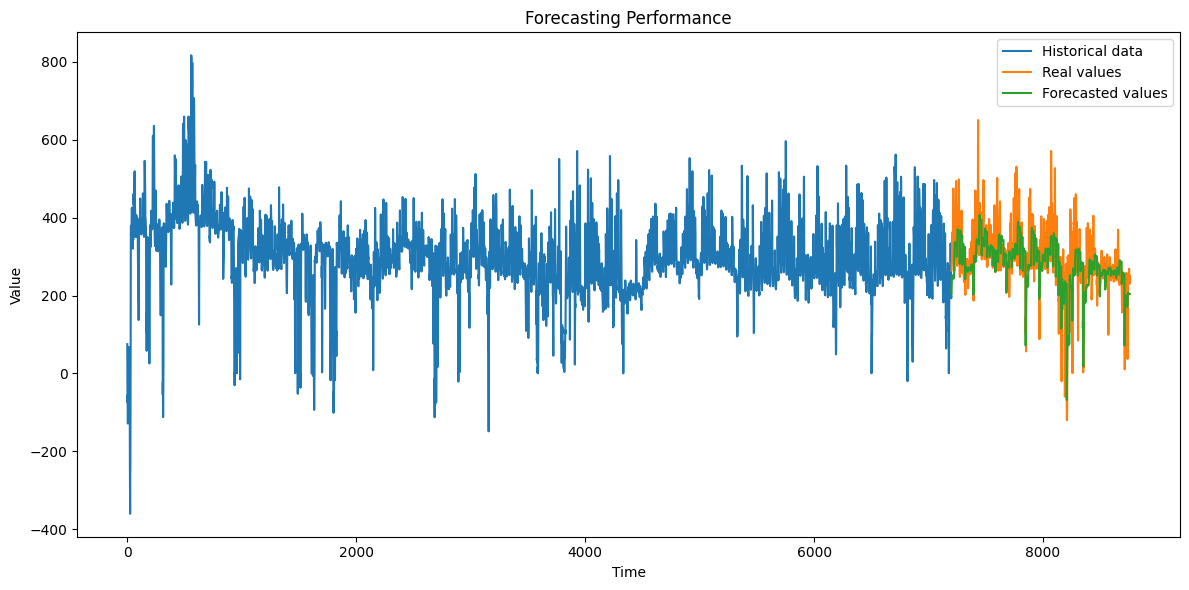

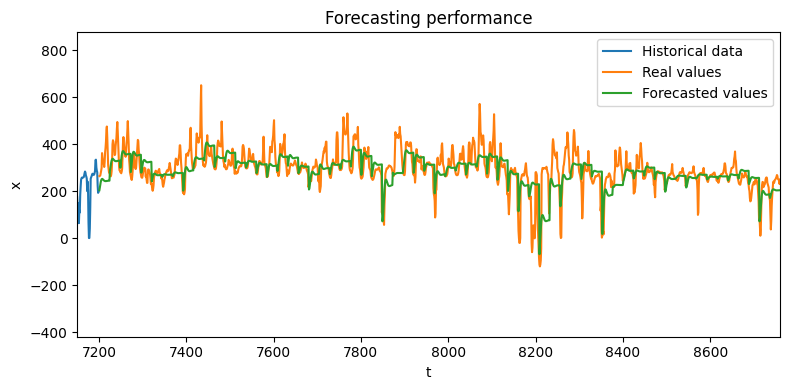

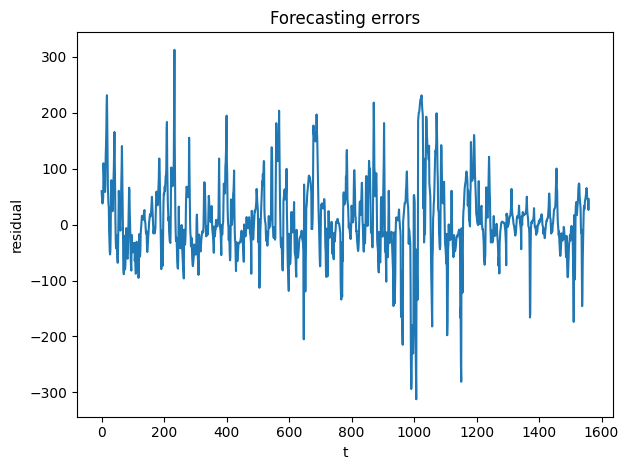

In [12]:
Plotting(train, test, result)

#### Et forsøg på Task 1.2 med exogenous variables

Det betyder, at persistence-modellen faktisk klarede sig bedre end ARIMA-modellen med eksterne input på den første dag

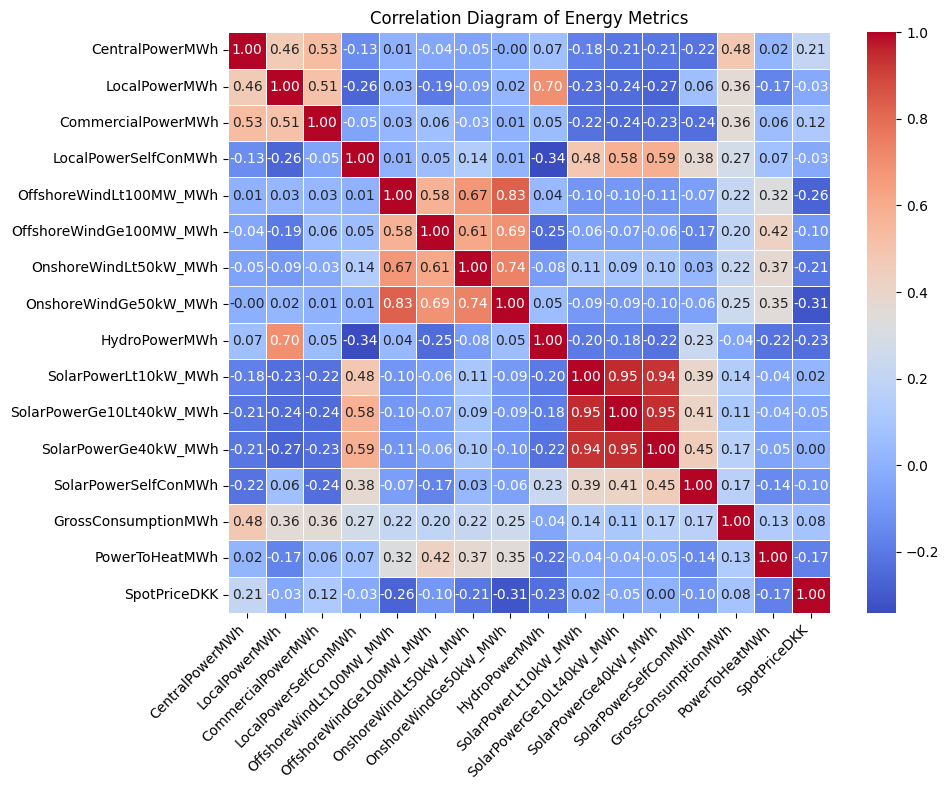

In [17]:
import seaborn as sns

# Select numeric columns for correlation analysis
numeric_data = df_data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

Targets = ['SpotPriceDKK']

Features = ['CentralPowerMWh',
            'LocalPowerMWh',
            'CommercialPowerMWh',
            'LocalPowerSelfConMWh',
            'OffshoreWindLt100MW_MWh',
            'OffshoreWindGe100MW_MWh',
            'OnshoreWindLt50kW_MWh',
            'OnshoreWindGe50kW_MWh',
            'HydroPowerMWh',
            'SolarPowerLt10kW_MWh',
            'SolarPowerGe10Lt40kW_MWh',
            'SolarPowerGe40kW_MWh',
            'SolarPowerSelfConMWh',
            'GrossConsumptionMWh',
            'PowerToHeatMWh',
            'SpotPriceDKK'
            ]


corr_subset = correlation_matrix.loc[Features, Targets]
# Set up matplotlib figure
plt.figure(figsize=(10, 8))
#colorpalet = 'greens'
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Diagram of Energy Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from pmdarima import arima
from pmdarima.preprocessing import FourierFeaturizer
from sklearn.metrics import mean_squared_error
from pmdarima.pipeline import Pipeline


# Load the data using the same logic as in your notebook
file_PE = os.path.join(os.getcwd(), 'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])

file_P = os.path.join(os.getcwd(), 'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])

# Merge datasets
merged_df = pd.merge(df_prices, df_data, on="HourUTC").dropna()

# We have chosen the exogenous variables based on a correlation heat map that showed high correlation with spotprices 
# The 3 highest correlated variables where all wind related and because they also correlates a lot with eachother we 
# chose these 3 which could give more diverse information 
Exovariables = ['OnshoreWindGe50kW_MWh', 'CentralPowerMWh', 'PowerToHeatMWh']

#Even though using the 3 most correlated variables gives us a smaller RMS value: 
Exovariables_wind = ['OnshoreWindGe50kW_MWh', 'OffshoreWindLt100MW_MWh', 'OnshoreWindLt50kW_MWh']


# Define input/output
X_full = merged_df[Exovariables]
y_full = merged_df["SpotPriceDKK"]

# Define train/test split based on time
train_mask = (merged_df["HourUTC"] >= "2023-01-01") & (merged_df["HourUTC"] <= "2023-08-31")
test_mask = (merged_df["HourUTC"] >= "2023-09-01") & (merged_df["HourUTC"] <= "2023-09-30")

X_train = X_full[train_mask.values]
X_test = X_full[test_mask.values]
y_train = y_full[train_mask.values]
y_test = y_full[test_mask.values]

# Add time index as a trend variable
X_train_ar = np.column_stack([np.arange(len(X_train)), X_train])
X_test_ar = np.column_stack([np.arange(len(X_train), len(X_train) + len(X_test)), X_test])

# Define and fit AutoARIMA pipeline
pipe = Pipeline([
    ("fourier", FourierFeaturizer(m=24, k=3)),
    ("arima", arima.AutoARIMA(stepwise=True, seasonal=False, suppress_warnings=True, maxiter=10))
])

pipe.fit(y_train, X=X_train_ar)

# Forecast full test period
y_pred = pipe.predict(n_periods=len(X_test_ar), X=X_test_ar)

# Calculate RMSE
rmse_autoarima = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_autoarima


401.0349223308118